<a href="https://colab.research.google.com/github/giorgiomorais/Projeto-Logistica-Loggi/blob/main/Projeto_An%C3%A1lise_de_Log%C3%ADstica_(Loggi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">


# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Projeto de Data Wrangling completo de informações logísticas da Startup Loggi, geração de visualizações gráficas e retirada de insights operacionais do Distrito Federal, considerando uma variação alta na densidade demográfica das 3 regiões atendidas. Também, objetivando responder às 3 principais questões:
* Questão 1: A quantidade de HUB's de distribuição está subdimensionada?
* Questão 2: A distribuição de entregas por HUB está equilibrada?


## 2\. Pacotes e bibliotecas

In [400]:
# Instalando e importando todas as bibliotecas utilizadas no projeto
!pip3 install geopandas
!pip install tabula-py PyPDF2

import json

import tabula
import PyPDF2
from PyPDF2 import PdfReader
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## 3\. Exploração de dados

### 3.1 Carregamento dos Dados

As informações de entregas logísticas estão disponíveis em um arquivo .json, logo, precisamos extrair as informações e transformar em um DataFrame do pandas para manipular mais facilmente os dados.

In [401]:
# Extraindo as informações de entregas de um arquivo json e carregando em um dict python
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Transformando o dict python em um DataFrame do pandas
deliveries_df = pd.DataFrame(data)

# Visualizando o DataFrame deliveries_df
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


### 3.2 Data Wrangling

Como pôde-se observar, há dados aninhados nas colunas "origin", então precisamos utilizar o método "json_normalize" do pandas para separar essas informações em colunas de um novo DataFrame.

In [402]:
# Normalizando a coluna origin (gera um novo dataframe com as informações da coluna "origin" separadas em colunas)
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145
...,...,...
194,-47.893662,-15.805118
195,-47.802665,-15.657014
196,-47.893662,-15.805118
197,-48.054989,-15.838145


Como o novo DataFrame gerado, podemos mesclar ao DataFrame original pelo index e então excluir a coluna "origin" original.

In [403]:
# Mesclando os DataFrames com o método merge do pandas por um inner join através dos index
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Excluindo a coluna "origin" original
deliveries_df = deliveries_df.drop("origin", axis=1)

# Selecionando e renomeando as novas colunas do DataFrame
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
...,...,...,...,...,...,...
194,cvrp-1-df-59,df-1,-47.893662,-15.805118,180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p..."
195,cvrp-0-df-87,df-0,-47.802665,-15.657014,180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p..."
196,cvrp-1-df-83,df-1,-47.893662,-15.805118,180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po..."
197,cvrp-2-df-7,df-2,-48.054989,-15.838145,180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p..."


Ainda há dados aninhados em diferentes níveis na coluna "deliveries", nesse caso, utilizaremos o método "explode" que gera, para cada registro, uma nova linha mantendo o indice original, após isso, separar as informações em colunas e dataframes novos.

In [404]:
# Aplicando o método "explode" à coluna "deliveries"
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
...,...
198,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
198,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
198,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
198,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."


In [405]:
# Criando um DataFrame diferente com uma coluna de cada informação e concatenando em um único DataFrame
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["id"])).rename(columns={"deliveries":"delivery_id"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_normalized_df

,delivery_size,delivery_id,delivery_lng,delivery_lat
0,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
0,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
0,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
0,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
0,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055
...,...,...,...,...
198,8,21693bf442ac5890adbdf2648c12881a,-48.064269,-15.997694
198,4,7aaa35088b37b6e542c4cd69663a7ebf,-48.065176,-16.003597
198,9,60c00d5390da4f28167439cd9c566703,-48.065841,-16.003808
198,1,51f456963785e7381243ff7baf7efd06,-48.062327,-16.001568


In [406]:
# Excluindo a coluna "deliveries" original
deliveries_df = deliveries_df.drop("deliveries", axis=1)

# Mesclando o novo DataFrame deliveries_normalized_df com o DataFrame original deliveries_df, right join pelo index
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_id,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,21693bf442ac5890adbdf2648c12881a,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,7aaa35088b37b6e542c4cd69663a7ebf,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,60c00d5390da4f28167439cd9c566703,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,51f456963785e7381243ff7baf7efd06,-48.062327,-16.001568


## 3.3 Análise Exploratória

Agora, com os dados estruturados em um DataFrame devidamente, partiremos para análise exploratória e limpeza dos dados.

In [407]:
# Ver as dimensões do DF
deliveries_df.shape

(636149, 9)

In [408]:
# Conhecer os tipos de dados e as colunas.
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_id       636149 non-null  object 
 7   delivery_lng      636149 non-null  float64
 8   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 43.7+ MB


In [409]:
# Identificar valores nulos
deliveries_df.isna().sum()

name                0
region              0
hub_lng             0
hub_lat             0
vehicle_capacity    0
delivery_size       0
delivery_id         0
delivery_lng        0
delivery_lat        0
dtype: int64

In [410]:
# Contar valores distintos nas colunas.
deliveries_df.nunique()

name                   199
region                   3
hub_lng                  3
hub_lat                  3
vehicle_capacity         1
delivery_size           10
delivery_id         291566
delivery_lng        291566
delivery_lat        291566
dtype: int64

In [411]:
# Separar os dados numéricos dos dados categóricos
var_numericos = []
var_categoricas = []

for coluna in deliveries_df.columns:
  if deliveries_df[coluna].dtype != "object":
    var_numericos.append(coluna)
  else:
    var_categoricas.append(coluna)

print(f'As colunas numéricas são: {var_numericos}')
print(f'As colunas categóricas são: {var_categoricas}')

As colunas numéricas são: ['hub_lng', 'hub_lat', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']
As colunas categóricas são: ['name', 'region', 'delivery_id']


In [412]:
# Ver um resumo estatístico dos dados numéricos.
deliveries_df[var_numericos].describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


Observação 1: Observa-se que os dados da coluna "vehicle_capacity" não apresentam variação, todos os valores são iguais a "180".
Observação 2: Os valroes da coluna "delivery_size" mostram que os volumes variam moderadamente, com uma média de 5.5121 e uma mediana de 6.0000, logo, desvio padrão de 2.8746, considerando a baixa amplitude, são variações relativamente moderadas.

In [413]:
# Ver um resumo dos dados categóricos.
deliveries_df[var_categoricas].describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
delivery_id,636149,291566,61b87669243974d021c2b76fc5272045,12


Observação 3: há 3 regiões principais dos HUB's, e a região que mais está relacionada a entregas é a região df-1 com 304708 registros.

## 4\. Manipulação

In [414]:
# Implementando o DataFrame de Área dos distritos do DF com Geopandas e arquivo .shp
mapa_df = gpd.read_file("./distrito-federal.shp")
mapa_df = mapa_df.loc[[0]]
if mapa_df.crs is None:
    mapa_df.crs = 'EPSG:4326'
mapa_df = mapa_df.to_crs(epsg=32723)
mapa_df['Area(km)'] = mapa_df.area / 10**6
mapa_df = pd.DataFrame(mapa_df)
mapa_df

,geometry,Area(km)
0,"POLYGON Z ((252785.743 8225703.192 0.000, 2527...",5784.571009


In [415]:
area_adm = gpd.read_file("./bairros-df.shp")
area_adm.crs = 'EPSG:32723'
area_adm = area_adm.to_crs(epsg=4326)

area_adm = pd.DataFrame(area_adm).reset_index()
area_adm["index"] = area_adm["index"]+1
area_adm = area_adm.rename(columns={"index":"id"})
area_adm

,id,geometry
0,1,"POLYGON ((-47.85950 -15.68823, -47.85951 -15.6..."
1,2,"POLYGON ((-48.03822 -15.94543, -48.03714 -15.9..."
2,3,"POLYGON ((-48.20825 -15.74034, -48.20778 -15.7..."
3,4,"POLYGON ((-47.76379 -15.52734, -47.76379 -15.5..."
4,5,"POLYGON ((-47.41841 -15.50182, -47.41841 -15.5..."
5,6,"POLYGON ((-47.66188 -15.73406, -47.66217 -15.7..."
6,7,"POLYGON ((-47.95455 -15.84839, -47.95465 -15.8..."
7,8,"POLYGON ((-47.97051 -15.80634, -47.97056 -15.8..."
8,9,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8..."
9,10,"POLYGON ((-48.04743 -15.85948, -48.04742 -15.8..."


In [416]:
dRA = pd.read_excel("dimRA.xlsx")
dRA = dRA[["id","RA","Pop 2015", "TMGCA (%)","AU (ha)","AT (ha)","DU 2015 (hab./ha)"]].rename(columns={"Pop 2015":"Pop","TMGCA (%)":"Var %","DU 2015 (hab./ha)":"DU"})
dRA

,id,RA,Pop,Var %,AU (ha),AT (ha),DU
0,23,Varjão,8453,-4.62,59.42,75.56,142.27
1,19,Candangolândia,15641,-3.76,113.85,662.70,137.38
2,9,Ceilândia,479713,3.03,3691.92,23401.14,129.94
3,15,Recanto das Emas,146906,2.81,1246.27,10261.11,117.88
4,14,São Sebastião,99525,0.31,882.69,35571.37,112.75
5,25,SCIA/Estrutural,38429,4.64,350.21,741.75,109.73
6,22,Sudoeste/Octogonal,52990,0.68,505.80,585.61,104.77
7,12,Samambaia,258457,6.39,2501.67,10125.85,103.31
8,11,Cruzeiro,29535,-4.20,290.60,323.05,101.63
9,4,Brazlândia,51816,0.68,554.03,47684.84,93.52


In [417]:
# URL = "https://pt.wikipedia.org/wiki/Regi%C3%B5es_administrativas_do_Distrito_Federal_(Brasil)"
# dRA = pd.read_html(URL, thousands=" ")[1]
# dRA = pd.DataFrame(dRA[["Região administrativa", "População[10][11]"]]).reset_index()
# dRA = dRA.rename(columns={"index":"id","Região administrativa":"RA","População[10][11]":"Pop"})
# dRA["id"] = dRA["id"] + 1
# dRA

Criando uma dimensão com as informações das regiões Administrativas.

In [418]:
dimRA = pd.merge(left=area_adm, right=dRA, how="inner", on="id")
dimRA

,id,geometry,RA,Pop,Var %,AU (ha),AT (ha),DU
0,1,"POLYGON ((-47.85950 -15.68823, -47.85951 -15.6...",Plano Piloto,210067,-1.49,10176.75,40989.31,20.64
1,2,"POLYGON ((-48.03822 -15.94543, -48.03714 -15.9...",Gama,134111,-0.31,2631.71,27559.42,50.96
2,3,"POLYGON ((-48.20825 -15.74034, -48.20778 -15.7...",Taguatinga,207045,-1.38,2572.11,8056.15,80.50
3,4,"POLYGON ((-47.76379 -15.52734, -47.76379 -15.5...",Brazlândia,51816,0.68,554.03,47684.84,93.52
4,5,"POLYGON ((-47.41841 -15.50182, -47.41841 -15.5...",Sobradinho,62763,-0.75,1503.93,20122.20,41.73
5,6,"POLYGON ((-47.66188 -15.73406, -47.66217 -15.7...",Planaltina,190495,1.37,2989.46,153847.95,63.72
6,7,"POLYGON ((-47.95455 -15.84839, -47.95465 -15.8...",Paranoá,44975,-1.37,487.46,78876.96,92.26
7,8,"POLYGON ((-47.97051 -15.80634, -47.97056 -15.8...",Núcleo Bandeirante,23562,-0.32,299.77,466.94,78.60
8,9,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8...",Ceilândia,479713,3.03,3691.92,23401.14,129.94
9,10,"POLYGON ((-48.04743 -15.85948, -48.04742 -15.8...",Guará,133171,5.38,1810.57,2562.92,73.55


## 5\. Visualização

In [419]:
# faça o código de visualização de dados:
#
# - produza pelo menos duas visualizações;
# - adicione um pequeno texto com os insights encontrados;
# - etc.

Mapa dos HUBS

In [420]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = gpd.GeoDataFrame(hub_df, geometry=gpd.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
if geo_hub_df.crs is None:
    geo_hub_df.crs = 'EPSG:4326'
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Mapa das Entregas

In [421]:
geo_deliveries_df = gpd.GeoDataFrame(deliveries_df, geometry=gpd.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
if geo_deliveries_df.crs is None:
    geo_deliveries_df.crs = 'EPSG:4326'
geo_deliveries_df = geo_deliveries_df.to_crs(epsg=4326)
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_id,delivery_lng,delivery_lat,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055,POINT (-48.11490 -15.85805)


Mapa DF

In [422]:
mapa = gpd.read_file("distrito-federal.shp")
if mapa.crs is None:
    mapa.crs = 'EPSG:4326'
mapa = mapa.to_crs(epsg=4326)
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Mapa RA

In [423]:
geo_ra_df = gpd.read_file("bairros-df.shp")
geo_ra_df.crs = 'EPSG:32723'
geo_ra_df = geo_ra_df.to_crs(epsg=4326)  # Reprojeta o GeoDataFrame das RAs para a mesma projeção do mapa
geo_ra_df.index = geo_ra_df.index+1
geo_ra_df.head()

,geometry
1,"POLYGON ((-47.85950 -15.68823, -47.85951 -15.6..."
2,"POLYGON ((-48.03822 -15.94543, -48.03714 -15.9..."
3,"POLYGON ((-48.20825 -15.74034, -48.20778 -15.7..."
4,"POLYGON ((-47.76379 -15.52734, -47.76379 -15.5..."
5,"POLYGON ((-47.41841 -15.50182, -47.41841 -15.5..."


In [424]:
crs_referencia = 'EPSG:4326'

# Reprojete todos os GeoDataFrames para a escala de referência
mapa = mapa.to_crs(crs_referencia)
geo_ra_df = geo_ra_df.to_crs(crs_referencia)
geo_deliveries_df = geo_deliveries_df.to_crs(crs_referencia)
geo_hub_df = geo_hub_df.to_crs(crs_referencia)


<ipython-input-425-279cdb191efd>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


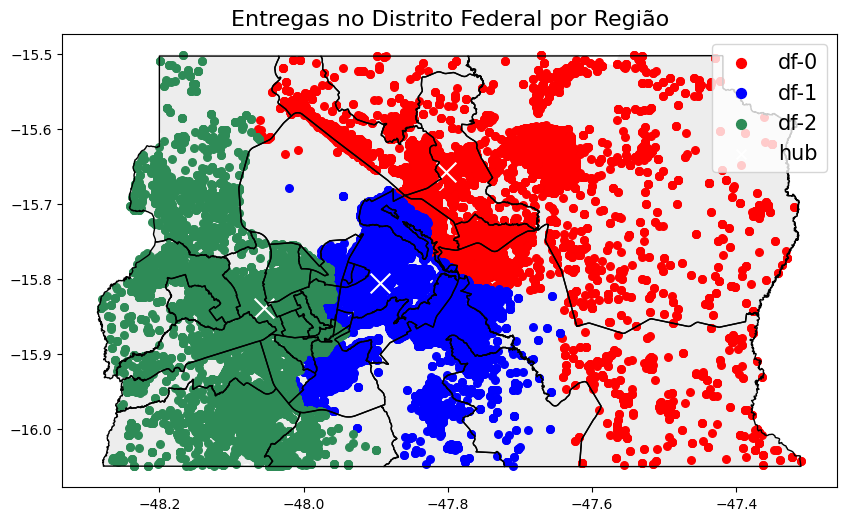

In [425]:
# cria o plot vazio
fig, ax = plt.subplots(figsize=(10, 10))  # Ajuste o tamanho conforme necessário

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=30, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=30, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=30, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=200, marker="x", color="white", label="hub")

# # plot das delimitações das RA's
geo_ra_df.boundary.plot(ax=ax, color="black", linewidth=1)

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

plt.show()

Pelo gráfico observamos que há Regiões Administrativas ainda com baixa atuação pelos HUB's. Ainda, que o HUB DF-1 opera em uma região bem mais concentrada do quê os outros HUB's, logo, provavelmente há custos operacionais bem mais elevados (principalmente combustível) para os HUB's DF-0 e DF-2.

Verificando as Regiões Administrativas atendidas por cada Hub.

In [426]:
entregasxRA = gpd.sjoin(geo_deliveries_df, geo_ra_df, how="inner", op="within")

# Agrupando as entregas por
entregasxRA = pd.DataFrame(entregasxRA.groupby(["region","index_right"])["delivery_id"].agg("count"))
entregasxRA["Fator"] = (entregasxRA.groupby(["region","index_right"])["delivery_id"].sum()/entregasxRA.groupby(["index_right"])["delivery_id"].sum())
entregasxRA = entregasxRA.reset_index()  #"index_right"
entregasxRA = entregasxRA.rename(columns={"region":"hub","index_right":"id", "delivery_id":"Qtd"})
entregasxRA = pd.merge(left=entregasxRA, right=dimRA, how="left", on= "id")
entregasxRA = entregasxRA.drop(columns="geometry")
entregasxRA["Potencial(hab)"] = entregasxRA["Fator"]*entregasxRA["Pop"]
entregasxRA

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,hub,id,Qtd,Fator,RA,Pop,Var %,AU (ha),AT (ha),DU,Potencial(hab)
0,df-0,1,26,0.000175,Plano Piloto,210067.0,-1.49,10176.75,40989.31,20.64,36.830002
1,df-0,3,16,0.002671,Taguatinga,207045.0,-1.38,2572.11,8056.15,80.50,552.949424
2,df-0,4,19296,1.000000,Brazlândia,51816.0,0.68,554.03,47684.84,93.52,51816.000000
3,df-0,5,19098,1.000000,Sobradinho,62763.0,-0.75,1503.93,20122.20,41.73,62763.000000
4,df-0,6,4740,0.940663,Planaltina,190495.0,1.37,2989.46,153847.95,63.72,179191.565787
5,df-0,12,6,0.000923,Samambaia,258457.0,6.39,2501.67,10125.85,103.31,238.465631
6,df-0,16,1492,0.054928,Lago Sul,28981.0,-2.73,4352.02,18342.78,6.66,1591.858484
7,df-0,23,19154,1.000000,Varjão,8453.0,-4.62,59.42,75.56,142.27,8453.000000
8,df-0,24,35,0.002353,Park Way,19803.0,0.19,5653.35,7646.32,3.50,46.592162
9,df-0,25,5553,1.000000,SCIA/Estrutural,38429.0,4.64,350.21,741.75,109.73,38429.000000


<ipython-input-436-15ac008cf108>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")


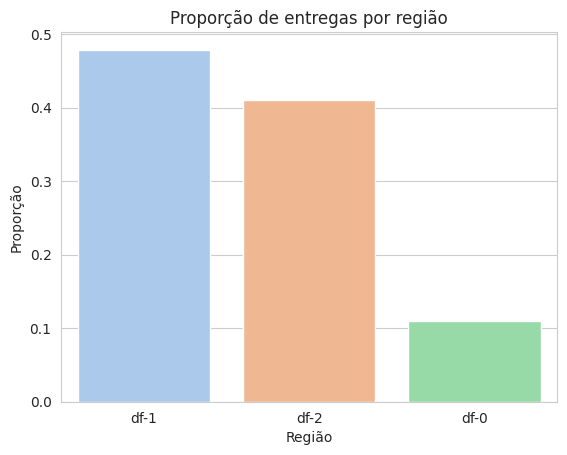

In [436]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

Analisando a proporção de entregas por HUB, observamos a baixa taxa do DF-0, podendo, então aproveitar melhor a sua atuação nas regiões administrativas 1, 3, 12 e 24. Considerando a densidade urbana das Regiões Administrativas, há muito a ser explorado pelo DF-0 nas regiões 3 e 28.

Já para o DF-1 as regiões 6, 17 e 18 têm alto potencial a ser explorado também.


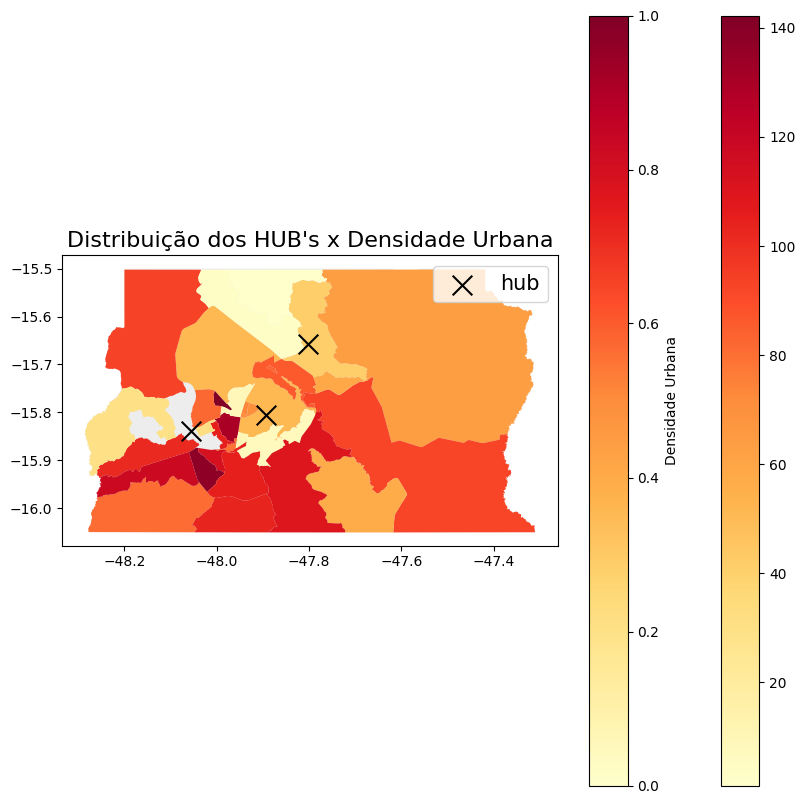

In [435]:
# cria o plot vazio
fig, ax = plt.subplots(figsize=(10, 10))

# plot mapa do Distrito Federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das delimitações das RA's com cores baseadas na densidade demográfica
geo_ra_df['color'] = dimRA['DU']  # Crie uma nova coluna 'color' com os valores de densidade demográfica
geo_ra_df.plot(column='color', cmap='YlOrRd', legend=True, ax=ax, linewidth=1)

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=200, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Distribuição dos HUB's x Densidade Urbana", fontdict={"fontsize": 16})

# Adicione a legenda
legenda = plt.legend(prop={"size": 15})

# Ajuste a legenda para a escala de cores
sm = plt.cm.ScalarMappable(cmap='YlOrRd')
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Densidade Urbana")

plt.show()

Percebemos ainda que, conforme o gráfico de Densidade Urbana, os HUB's poderiam estar melhor distribuidos, ou simplesmente posicionados mais a sul do mapa. Em especial o DF-0 que deveria estar mais próximo da região de Paranoá onde a Densidade Urbana é mais acentuada, ou seja, mais provável a ocorrência de entregas.